## Setting up: 

In [52]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
import datetime
# importing the module
import json
import os

%load_ext autoreload
%autoreload 2

#additional functions:
from helper_functions.helper_functions import *
from helper_functions.ml_methods_labs import *

import warnings
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load Data: 

- train.csv - Training set of 250000 events. The file starts with the ID column, then the label column (the y you have to predict), and finally 30 feature columns.
- test.csv - The test set of around 568238 events - Everything as above, except the label is missing.
- sample-submission.csv - a sample submission file in the correct format. The sample submission always predicts -1, that is ‘background’.

**Note:**
- all variables are floating point, except PRI_jet_num which is integer
- variables prefixed with PRI (for PRImitives) are “raw” quantities about the bunch collision as measured by the detector.
- variables prefixed with DER (for DERived) are quantities computed from the primitive features, which were selected by the physicists of ATLAS.
- it can happen that for some entries some variables are meaningless or cannot be computed; in this case, their value is −999.0, which is outside the normal range of all variables.

In [53]:
DATA_TRAIN_PATH = '../data/train.csv'
y, tX, ids = load_csv_data(DATA_TRAIN_PATH)
print(f'training data shape: y {y.shape}, X {tX.shape}')

training data shape: y (250000,), X (250000, 30)


In [54]:
data_ind = ['DER_mass_MMC', 'DER_mass_transverse_met_lep', 'DER_mass_vis',
       'DER_pt_h', 'DER_deltaeta_jet_jet', 'DER_mass_jet_jet',
       'DER_prodeta_jet_jet', 'DER_deltar_tau_lep', 'DER_pt_tot', 'DER_sum_pt',
       'DER_pt_ratio_lep_tau', 'DER_met_phi_centrality',
       'DER_lep_eta_centrality', 'PRI_tau_pt', 'PRI_tau_eta', 'PRI_tau_phi',
       'PRI_lep_pt', 'PRI_lep_eta', 'PRI_lep_phi', 'PRI_met', 'PRI_met_phi',
       'PRI_met_sumet', 'PRI_jet_num', 'PRI_jet_leading_pt',
       'PRI_jet_leading_eta', 'PRI_jet_leading_phi', 'PRI_jet_subleading_pt',
       'PRI_jet_subleading_eta', 'PRI_jet_subleading_phi', 'PRI_jet_all_pt']

Plot histogram of raw data:

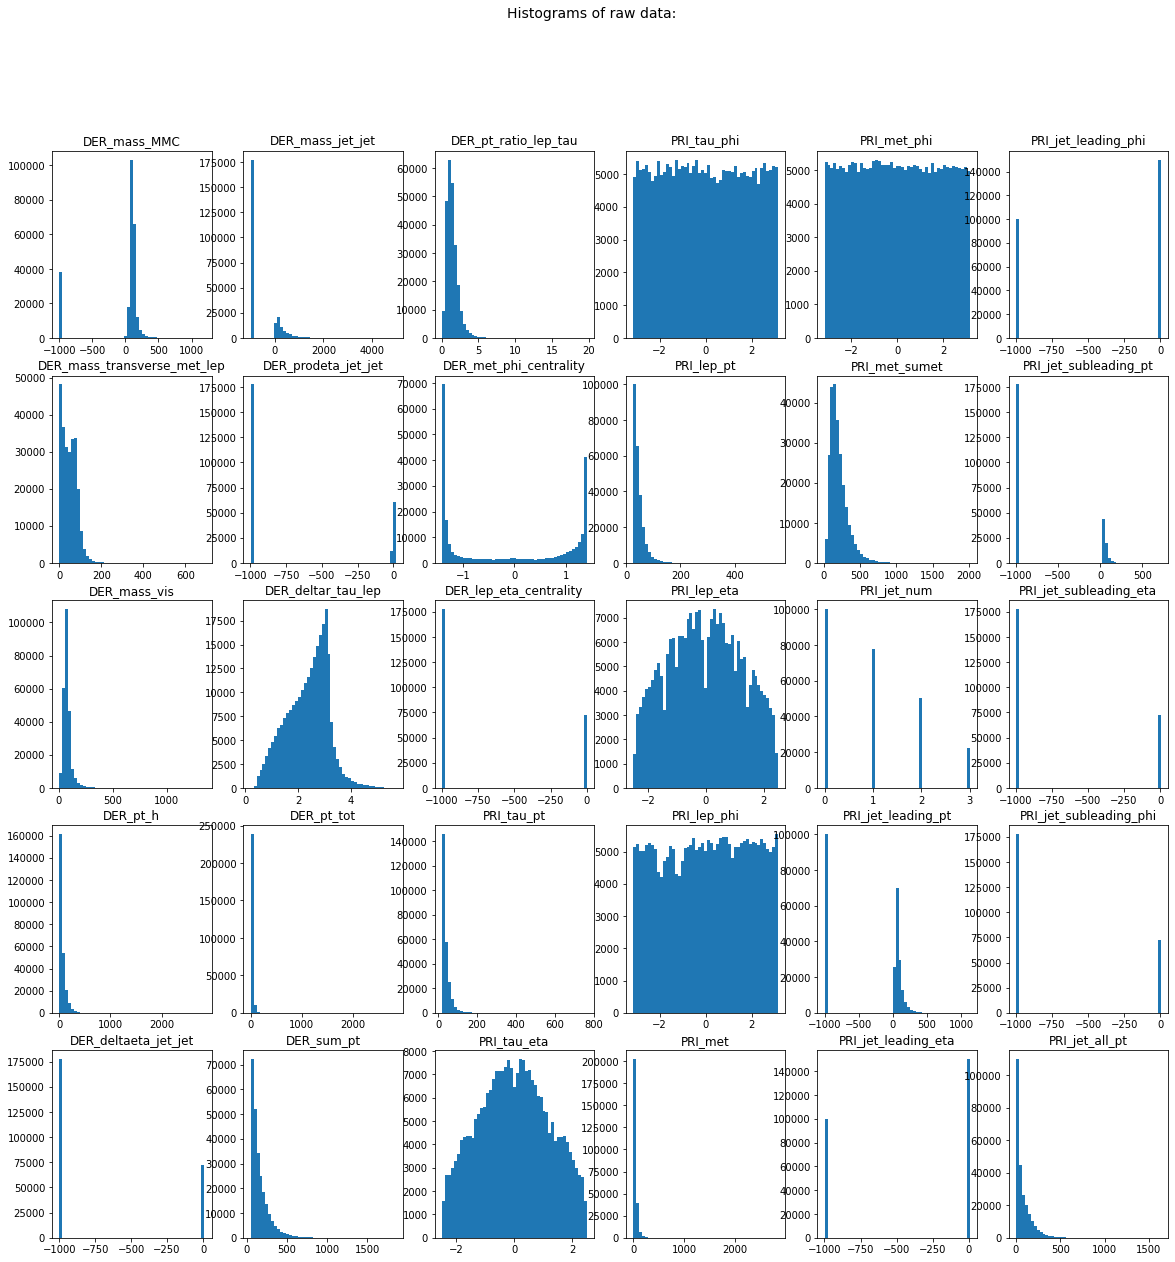

In [55]:
fig, axs = plt.subplots(5, 6, figsize=(20, 20))
m = 0
for i in range(6):
    for j in range(5):
        bins = np.linspace(np.min(tX[:, m]), np.max(tX[:, m]), 50)
        axs[j, i].hist(tX[:, m], bins = bins)
        axs[j, i].set_title(data_ind[m])
        m += 1
plt.suptitle('Histograms of raw data:', fontsize=14)
fig.show()

### Pre-processing:

#### Invalid values:
Histogram after replacing -999 values:

In [56]:
def replace_invalid_values(tX, invalid_identifier, mean=True):
    """Replaces invalid values with the mean of all the values in the cooresponding feature """
    means = []
    data = tX.copy()
    new_data = np.empty((tX.shape[0], 1))

    for i in range(0, tX.shape[1]):
        # deleting all occurences of invalid_identifier:
        column = data[:, i].copy()
        column = np.delete(column, np.where(column == invalid_identifier))
        if mean:
            # replacing all the invalid data with the above
            data[:, i] = np.where(data[:, i] == invalid_identifier,
                                  np.mean(column), data[:, i])
            new_data = np.concatenate(
                (new_data, np.reshape(data[:, i], (tX.shape[0], 1))), axis=1)
            means.append(np.mean(column))
        else:
            data[:, i] = np.where(data[:, i] == invalid_identifier,
                                  np.median(column), data[:, i])
            new_data = np.concatenate(
                (new_data, np.reshape(data[:, i], (tX.shape[0], 1))), axis=1)
            means.append(np.median(column))
    assert(new_data[:, 1:].shape == tX.shape)
    return new_data[:, 1:], means

In [57]:
invalid_identifier = -999
tX_invalid, medians = replace_invalid_values(tX,
                                              invalid_identifier,
                                              mean=False)

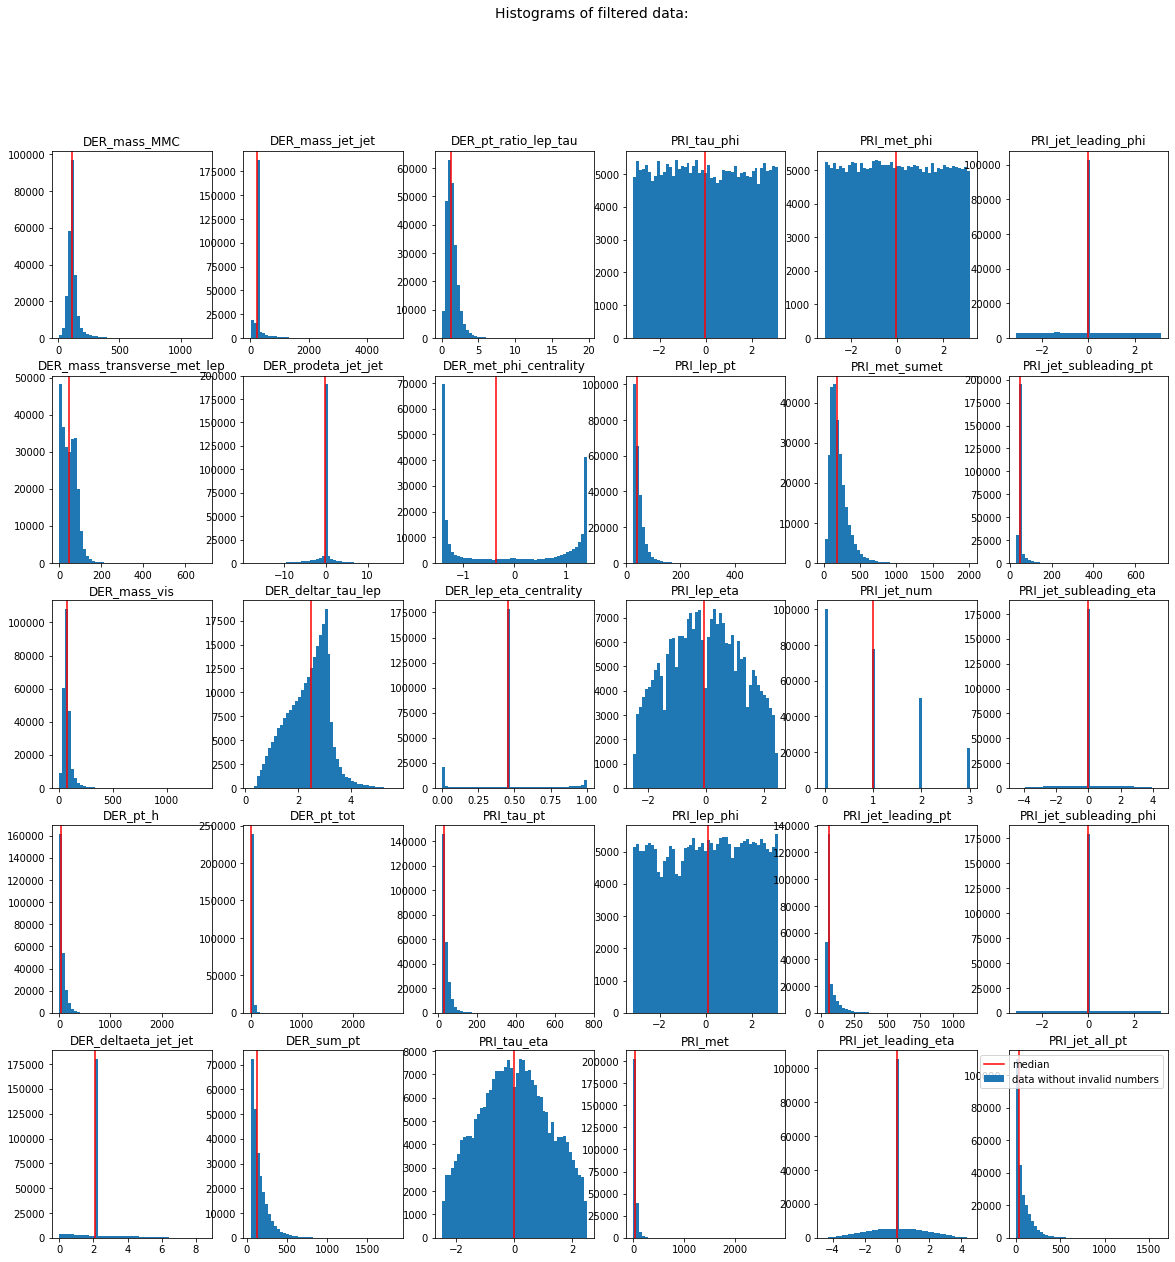

In [58]:
fig, axs = plt.subplots(5, 6, figsize=(20, 20))
m = 0
for i in range(6):
    for j in range(5):
        bins = np.linspace(np.min(tX_invalid[:, m]), np.max(tX_invalid[:, m]), 50)
        axs[j, i].hist(tX_invalid[:, m], bins=bins, label = 'data without invalid numbers')
        axs[j, i].set_title(data_ind[m])
        axs[j, i].axvline(medians[m], color='r', label = 'median')
        m += 1
plt.legend()
plt.suptitle('Histograms of filtered data:', fontsize=14)
fig.show()

#### Outliers: 

In [59]:
### Outlayers removing
# we consider a value as outlay when x > delta*std_deviationtX = replace_outlayers_values_with_mean(tX, delta)
def replace_outlayers_values(features, delta, mean=True):
    """Replaces outlayers values with the mean of all the values in the cooresponding feature """
    medians = []
    new_data = np.empty((len(features), 1))
    for i in range(30):
        column = features[:, i].copy()
        Q1 = np.quantile(column, 0.10)
        Q3 = np.quantile(column, 0.75)
        IQR = Q3 - Q1
        if mean:
            mean = np.mean(column)
            col_no_outl = np.where(
                ~((column < (Q1 - delta * IQR)) | (column > (Q3 + delta * IQR))),
                column, mean)
            new_data = np.concatenate(
                (new_data, np.reshape(col_no_outl, (len(features), 1))), axis=1)
            medians.append(mean)
        else:
            median = np.median(column)
            col_no_outl = np.where(
                ~((column < (Q1 - delta * IQR)) | (column > (Q3 + delta * IQR))),
                column, median)
            new_data = np.concatenate(
                (new_data, np.reshape(col_no_outl, (len(features), 1))), axis=1)
            medians.append(median)
    return new_data[:,1:], medians

In [60]:
delta = 1.5
tX_filtered, medians = replace_outlayers_values(tX_invalid, delta, mean = False)

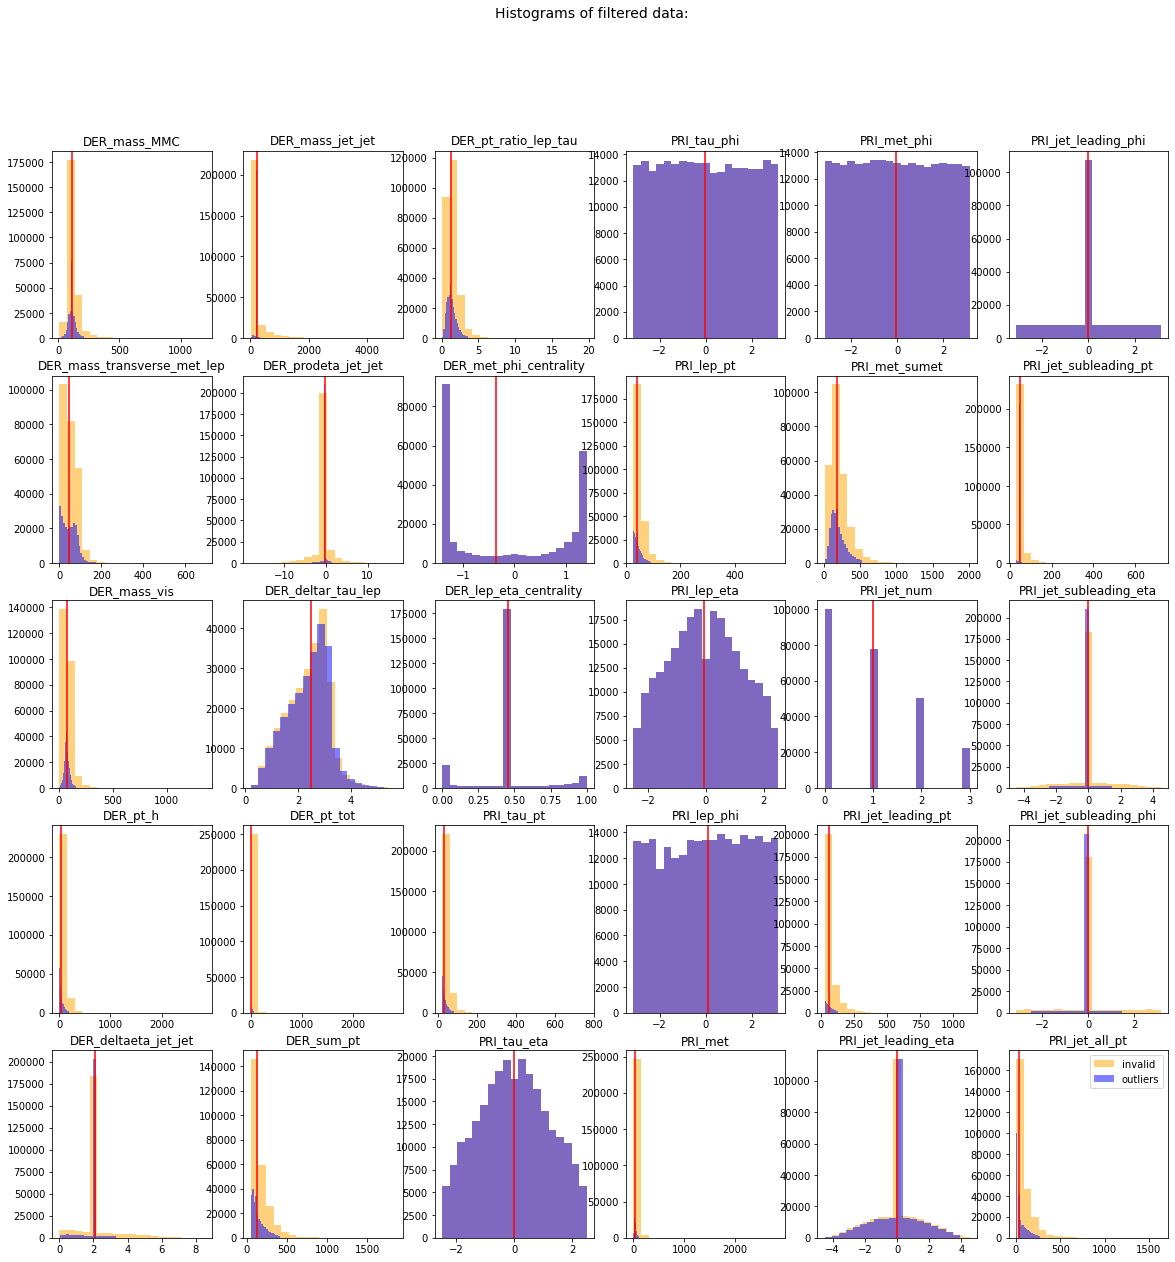

In [61]:
fig, axs = plt.subplots(5, 6, figsize=(20, 20))
m = 0
for i in range(6):
    for j in range(5):
        bins1 = np.linspace(np.min(tX_filtered[:, m]),
                           np.max(tX_filtered[:, m]), 20)
        bins2 = np.linspace(np.min(tX_invalid[:, m]),
                           np.max(tX_invalid[:, m]), 20)
        
        axs[j, i].hist(tX_invalid[:, m],
                       color='orange',
                       bins=bins2,
                       alpha=0.5,
                       label='invalid')
        axs[j, i].hist(tX_filtered[:, m],
                       color='blue',
                       bins=bins1,
                       alpha=0.5,
                       label='outliers')
        axs[j, i].set_title(data_ind[m])
        axs[j, i].axvline(medians[m], color='r')
        m += 1
plt.legend()
plt.suptitle('Histograms of filtered data:', fontsize=14)
fig.show()

#### Encoding of y: 

In [62]:
### Encoding of y: 
y_enc = (y+1)/2
y = y_enc

#### Choose data: 

In [63]:
tX = tX_filtered    

## Implement ML methods:

You should take care of the following:
- Return type: Note that all functions should return: (w, loss), which is the last weight vector of the method, and the corresponding loss value (cost function). Note that while in previous labs you might have kept track of all encountered w for iterative methods, here we only want the last one.
- File names: Please provide all function implementations in a single python file, called implementations.py.
- All code should be easily readable and commented.
- Note that we might automatically call your provided methods and evaluate for correct implementation

### Cross validation:
Create cross validation method in order to evaluate the loss better. 

In [64]:
def build_k_indices(y, k_fold, seed=2):
    """build k indices for k-fold."""
    num_row = y.shape[0]
    interval = int(num_row / k_fold)
    np.random.seed(seed)
    indices = np.random.permutation(num_row)
    k_indices = [indices[k * interval: (k + 1) * interval]
                 for k in range(k_fold)]
    return np.array(k_indices)

In [65]:
def cross_validation_sets(tX, y, k_indices,i):
    """
    cross_validation_sets: separates tX and y randomly into training and validation sets. 
    @input:
    - np.array(N,) y: labels
    - np.array(N,m) tx: features
    - int K: number of folds during k-fold cross-val
    @output: 
    - np.array(percentage*N,m) tX_train: training features
    - np.array(percentage*N,) y_train: training labels
    - np.array((1-percentage)*N,m) tX_val: validation features
    - np.array((1-percentage)**N,) y_val: validation labels
    """
    
    train_indices = np.concatenate(np.delete(k_indices, i, axis = 0), axis = 0)
    val_indices = k_indices[i]
    
    #creates training and validation:
    tX_train = np.take(tX, train_indices, axis = 0)
    y_train = np.take(y, train_indices, axis = 0)
    tX_val = np.take(tX, val_indices, axis = 0)
    y_val = np.take(y, val_indices, axis = 0)
    
    size = len(train_indices) + len(val_indices)
    
    assert (tX_train.shape[0] + tX_val.shape[0] == size)
    assert (y_train.shape[0] + y_val.shape[0] == size)

    return tX_train, y_train, tX_val, y_val

Different models that will be trainable:

In [66]:
models = {
    'LS_GD': 'Least squares with GD',
    'LS_SGD': 'Least squares with SGD',
    'LS_normal': 'Least squares with normal equations',
    'RR_normal': 'Ridge regression with normal equations',
    'LR': 'Logistic regression with GD'
}

Default json parameters for training, for special parameters take other file or create your own dictionary: 

In [68]:
with open('parameters/default_parameters.json') as json_file:
    default_parameters = json.load(json_file)

### Feature expansion:
Polynomial feature expansion: $X' = [1, X, X^2]$

In [69]:
def poly_feats(tX, degree):  
    if not np.array_equal(tX[:, 0], np.ones(len(tX))):
            # add bias term:
            tX_poly = np.hstack((np.ones((len(tX), 1)), tX))
    if degree>1: 
        for deg in range(2, degree+1):
            tX_poly = np.c_[tX_poly, np.power(tX, deg)]
    return tX_poly

assert (np.array_equal(
    poly_feats(tX, 2)[:, 1:31],
    tX[:, 0:30]))

In [70]:
# accuracy:
def accuracy(feautres, w, true_y):
    y_pred = predict_labels(w, feautres)
    # encode to 0/1
    y_pred_enc = (y_pred+1)/2
    P_N = len(y_pred_enc[np.where(np.subtract(y_pred_enc, true_y)==0)])
    #return sklearn.metrics.accuracy_score(y_pred_enc, true_y), (P_N/len(y_val))
    return (P_N/len(true_y))*100

### Training: 
Global training function where each model can be called.

In [71]:
def train_model(tX,
                y,
                model='LS_GD',
                initial_w=None,
                param=default_parameters,
                verbose=True):
    """
    train_model: trains a model according to their parameters in the dictionnary
    @input:
        - np.array(N,) y: labels
        - np.array(N,m) tX: features
        - string model: 'LS_GD', 'LS_SGD', 'LS_normal', 'RR_normal' or 'LR'
        - np.array(m,) initial_w: starting weights for GD and SGD
        - dictionary param: different parameters required for training (lr, lambda, etc)
    @output: 
        - np.array(m,) best_w: weights that got the smallest loss during cross-val
        - double avg_loss: average loss over validation sets during cross-val
    """
    # will keep last weights and last loss
    weights, loss = [], []
    parameters = param[model]

    # parameters:
    K, MAX_ITERS, POLY = parameters['K'], parameters['max_iters'], parameters[
        'poly']

    # will keep all losses during training
    costs_ = np.zeros([K, MAX_ITERS])
    train_costs_ = np.zeros([K, MAX_ITERS])

    if verbose:
        print(
            f'{models[model]} starting with: \nInitial_w: {initial_w},\nParameters:{parameters}'
        )
        print('------------------')
        print('START TRAINING:')

    # get indices of k-fold:
    k_indices = build_k_indices(y, K)

    # polynonmial expansion:
    tX_pol = poly_feats(tX, POLY)

    # standardize:
    tX_std = standardize(tX_pol)

    if verbose:
        print(f'Data shape:{tX_std.shape}')

    # initial_w:
    if initial_w == None:
        initial_w = np.zeros(tX_std.shape[1])

    for i in range(K):
        if verbose:
            print(f'K = {i+1}')
        # create training and validation sets:
        tX_train, y_train, tX_val, y_val = cross_validation_sets(
            tX_std, y, k_indices, i)

        #start with initial_w:
        w = initial_w.copy()
        # keep tabs on losses during training
        cost_history = []
        train_cost_history = []

        # if RR_normal or LS_normal no GD:
        if model == 'RR_normal':
            w, cost_history = ridge_regression_update(tX_train, y_train,
                                                      tX_val, y_val,
                                                      parameters)
            cost = cost_history
            acc = accuracy(tX_val, w, y_val)
            if verbose:
                print(f'Final loss:{cost}')
                print(f'Final accuracy:{acc}')

        elif model == 'LS_normal':
            w, cost_history = least_squares_update(tX_train, y_train, tX_val,
                                                   y_val)
            acc = accuracy(tX_val, w, y_val)
            cost = cost_history
            if verbose:
                print(f'Final loss:{cost}')
                print(f'Final accuracy:{acc}')

        # else GD:
        else:
            for j in range(MAX_ITERS):
                if model == 'LR':
                    # calculate loss:
                    cost = cost_logistic(tX_val, y_val, w, parameters)
                    cost_history.append(cost)
                    train_cost_history.append(
                        cost_logistic(tX_train, y_train, w, parameters))
                    # Update weights:
                    w = update_weights_logistic(tX_train, y_train, w,
                                                parameters)
                    acc = accuracy(tX_val, w, y_val)
                if model == 'LS_GD':
                    # calulate loss:
                    cost = MSE_loss(tX_val, y_val, w)
                    cost_history.append(cost)
                    train_cost_history.append(MSE_loss(tX_train, y_train, w))
                    # Update weights:
                    w = update_weights_LS_GD(tX_train, y_train, w, parameters)
                    acc = accuracy(tX_val, w, y_val)
                if model == 'LS_SGD':
                    # calulate loss:
                    cost = MSE_loss(tX_val, y_val, w)
                    cost_history.append(cost)
                    train_cost_history.append(MSE_loss(tX_train, y_train, w))
                    # update weights:
                    w = update_weights_LS_SGD(tX_train, y_train, w, parameters)
                    acc = accuracy(tX_val, w, y_val)
            if verbose:
                print(f'Final loss:{cost}')
                print(f'Final accuracy:{acc}')
        # Add last weights and loss for auditing:
        weights.append(w)
        loss.append(cost)
        costs_[i] = cost_history
        if model != 'LS_normal' and model != 'RR_normal':
            train_costs_[i] = train_cost_history
        if verbose:
            print('------------------')

    if verbose:
        print('Average loss: {avg_loss}'.format(avg_loss=np.mean(loss)))

    # best weights of min loss:
    best_w = weights[np.argmin(loss)]

    # Plot loss evolution for GD:
    if model != 'LS_normal' and model != 'RR_normal' and verbose:
        print('------------------')
        print('Loss evolution:')
        fig, ax = plt.subplots(1, 2, figsize=(10, 5))
        ax[0].plot(costs_.T)
        ax[0].set_title(models[model] + ' , validation loss')
        ax[0].legend(range(1, K + 1))
        ax[1].plot(train_costs_.T)
        ax[1].set_title(models[model] + ' , training loss')
        ax[1].legend(range(1, K + 1))

    return best_w, np.mean(loss)

### Least Squares GD: 
Linear regression using gradient descent. 

In [72]:
def gradient_MSE(tX, y, w):
    """
    gradient_MSE: calculates the gradient of the MSE function 
    @input:
    - np.array(N,) y: labels
    - np.array(N,m) tX: features
    - np.array(m,) w: weights
    @output: np.array(m,) gradient of MSE
    """
    return (-1 / len(y)) * tX.T @ (y - tX @ w)

In [73]:
def MSE_loss(tX, y, w):
    """
    MSE_loss: calculates the MSE loss
    @input:
    - np.array(N,) y: labels
    - np.array(N,m) tX: features
    - np.array(m,) w: weights
    @output: double, MSE loss
    """
    assert(w.shape[0] == tX.shape[1])
    assert(y.shape[0] == tX.shape[0])
    MSE = np.square(np.subtract(y,tX @ w)).mean()
    return MSE

In [74]:
def update_weights_LS_GD(tX, y, w, parameters):
    """
    update_weights_LS_GD: one step of GD with MSE
    @input:
    - np.array(N,) y: labels
    - np.array(N,m) tX: features
    - np.array(m,) w: weights
    - dict parameters: dictionnary of required parameters
    @output: updated weights according to GD
    """
    # get parameters:
    lr = parameters['lr']
    # calculate gradient:
    grad = gradient_MSE(tX, y, w)
    # update weights:
    w -= lr * grad
    return w

In [75]:
def least_squares_GD(tX, y, initial_w, parameters):
    """
    least_squares_GD: training with least squares GD
    @input:
    - np.array(N,m) tX: features
    - np.array(N,) y: labels
    - np.array(m,) initial_w: starting weights
    - dict parameters: dictionnary of required parameters
    @output: 
    - np.array(m,) best_w: weights that got the smallest loss during cross-val
    - double avg_loss: average loss over validation sets during cross-val
    """
    model = 'LS_GD'
    best_w, avg_loss = train_model(tX=tX,
                                   y=y,
                                   model=model,
                                   initial_w=initial_w,
                                   param=parameters)

    return best_w, avg_loss

Least squares with GD starting with: 
Initial_w: None,
Parameters:{'lr': 0.01, 'max_iters': 100, 'K': 5, 'poly': 2}
------------------
START TRAINING:
Data shape:(250000, 61)
K = 1
Final loss:0.18064106937115357
Final accuracy:50.078
------------------
K = 2
Final loss:0.18174897454092012
Final accuracy:49.95
------------------
K = 3
Final loss:0.18102590843606045
Final accuracy:50.066
------------------
K = 4
Final loss:0.18083570826325485
Final accuracy:50.552
------------------
K = 5
Final loss:0.18042107984413108
Final accuracy:50.166
------------------
Average loss: 0.18093454809110399
------------------
Loss evolution:


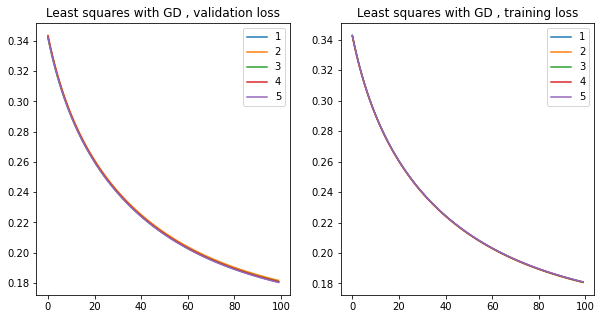

In [77]:
# polynomial feature expansion:
with open('parameters/default_parameters.json') as json_file:
    default_parameters = json.load(json_file)

best_w, avg_loss = least_squares_GD(tX=tX,
                                    y=y,
                                    initial_w=None,
                                    parameters=default_parameters)

### Least Squares SGD:
Linear regression using stochastic gradient descent

In [78]:
def update_weights_LS_SGD(tX, y, w, parameters):
    """
    update_weights_LS_SGD: one step of SGD with MSE
    @input:
    - np.array(N,) y: labels
    - np.array(N,m) tX: features
    - np.array(m,) w: weights
    - dict parameters: dictionnary of required parameters
    @output: updated weights according to SGD
    """   
    # get parameters:
    lr = parameters['lr']
    # batch_size to 1 for SGD, otherwise mini-batch:
    batch_size = parameters['batch_size']

    for minibatch_y, minibatch_tX in batch_iter(y, tX, batch_size):
        # calculate gradient on batch:
        grad = gradient_MSE(minibatch_tX, minibatch_y, w)
        # update weights:
        w -= lr * grad
    return w

In [79]:
def least_squares_SGD(tX, y, initial_w, parameters):
    """
    least_squares_SGD: training with least squares SGD
    @input:
    - np.array(N,) y: labels
    - np.array(N,m) tX: features
    - np.array(m,) initial_w: starting weights
    - dict parameters: dictionnary of required parameters
    @output: 
    - np.array(m,) best_w: weights that got the smallest loss during cross-val
    - double avg_loss: average loss over validation sets during cross-val
    """
    model = 'LS_SGD'
    best_w, avg_loss = train_model(tX=tX,
                                   y=y,
                                   model=model,
                                   initial_w=initial_w,
                                   param=parameters)
    return best_w, avg_loss

Least squares with SGD starting with: 
Initial_w: None,
Parameters:{'lr': 0.01, 'max_iters': 100, 'K': 5, 'poly': 2, 'batch_size': 1}
------------------
START TRAINING:
Data shape:(250000, 61)
K = 1
Final loss:0.316707353040594
Final accuracy:51.81400000000001
------------------
K = 2
Final loss:0.279953900172351
Final accuracy:52.138
------------------
K = 3
Final loss:0.34390824206426274
Final accuracy:43.314
------------------
K = 4
Final loss:0.24589164080845893
Final accuracy:53.238
------------------
K = 5
Final loss:0.2807356226329816
Final accuracy:54.008
------------------
Average loss: 0.29343935174372965
------------------
Loss evolution:


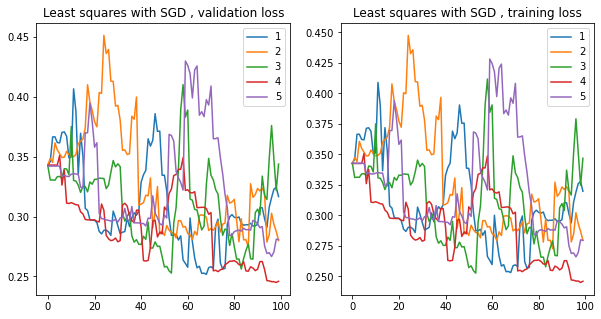

In [82]:
# Test of LS-SGD:
with open('parameters/default_parameters.json') as json_file:
    default_parameters = json.load(json_file)
best_w, avg_loss = least_squares_SGD(tX=tX,
                                     y=y,
                                     initial_w=None,
                                     parameters=default_parameters)

### Least Squares:
Least squares regression using normal equations. Solve $A^TAx = A^Ty$, Ax = b → x = np.linalg.solve(A, b)

In [83]:
def least_squares_update(tX_train, y_train, tX_val, y_val):
    """
    least_squares_update: weights with normal equations of least squares
    @input:
    - np.array(N,) y_train and y_val: training and validation labels
    - np.array(N,m) tX_train and tX_val: training and validation features
    @output: 
    - np.array(m,) w: weights 
    - double loss: MSE loss
    """
    # "train":
    w = np.linalg.solve(tX_train.T @ tX_train, tX_train.T @ y_train)
    # evaluate loss on validation set:
    loss = MSE_loss(tX_val,y_val, w)
    return w, loss

Pas nécessaire de garder cette fonction `least_squares` si c'est ok d'avoir juste une fx train, un peu inutile... 


In [84]:
def least_squares(y, tX, parameters):
    """
    least_squares: weights with normal equations of least squares
    @input:
    - np.array(N,) y: labels
    - np.array(N,m) tx: features
    @output:
    - np.array(m,) best_w: weights with smallest loss during cross-val 
    - double avg_loss: average loss over validation sets during cross-val
    """
    model = 'LS_normal'
    best_w, avg_loss = train_model(tX=tX, y=y, model=model, param=parameters)
    return best_w, avg_loss

In [85]:
# Test of LS_normal:
with open('parameters/default_parameters.json') as json_file:
    default_parameters = json.load(json_file)
best_w, avg_loss = least_squares(y=y, tX=tX, parameters=default_parameters)

Least squares with normal equations starting with: 
Initial_w: None,
Parameters:{'max_iters': 1, 'K': 5, 'poly': 2}
------------------
START TRAINING:
Data shape:(250000, 61)
K = 1
Final loss:0.1505672449983904
Final accuracy:42.364000000000004
------------------
K = 2
Final loss:0.15193841401774985
Final accuracy:42.704
------------------
K = 3
Final loss:0.15101221194527142
Final accuracy:42.606
------------------
K = 4
Final loss:0.15036531549635748
Final accuracy:42.966
------------------
K = 5
Final loss:0.15066445171444925
Final accuracy:42.782
------------------
Average loss: 0.1509095276344437


### Ridge Regression: 
Ridge regression using normal equations. $w^* = (X^T X+\lambda I)^{-1}X^Ty$

In [86]:
def ridge_regression_update(tX_train, y_train, tX_val, y_val, parameters):
    """
    least_squares_update: weights with normal equations of least squares
    @input:
    - np.array(N,) y_train and y_val: training and validation labels
    - np.array(N,m) tX_train and tX_val: training and validation features
    - dict parameters: dictionnary of required parameters
    @output:
    - np.array(m,) w: weights 
    - double loss: MSE loss
    """
    # get parameters:
    lambda_ = parameters['lambda_']

    # "train":
    w = np.linalg.solve(
        tX_train.T @ tX_train + lambda_ * np.eye(tX_train.shape[1]),
        tX_train.T @ y_train)

    # evaluate loss on validation set:
    loss = MSE_loss(tX_val, y_val, w)
    return w, loss

A nouveau, pas nécessaire de garder cette fonction `ridge_regression` si c'est ok d'avoir juste une fx train, un peu inutile...

In [87]:
def ridge_regression(y, tX, parameters):
    """
    ridge_regression: weights with normal equations of ridge regression
    @input:
    - np.array(N,) y: labels
    - np.array(N,m) tx: features
    @output:
    - np.array(m,) best_w: weights with smallest loss during cross-val 
    - double avg_loss: average loss over validation sets during cross-val
    """     
    model = 'RR_normal'
    best_w, avg_loss = train_model(tX = tX, y= y, 
                                   model=model,
                                   param=parameters)
    return best_w, avg_loss

In [88]:
# Test of RR_normal:
with open('parameters/default_parameters.json') as json_file:
    default_parameters = json.load(json_file)
best_w, avg_loss = ridge_regression(y = y, tX = tX, parameters = default_parameters)

Ridge regression with normal equations starting with: 
Initial_w: None,
Parameters:{'max_iters': 1, 'K': 5, 'lambda_': 0.02, 'poly': 2}
------------------
START TRAINING:
Data shape:(250000, 61)
K = 1
Final loss:0.15056724679963066
Final accuracy:42.364000000000004
------------------
K = 2
Final loss:0.15193841348841056
Final accuracy:42.704
------------------
K = 3
Final loss:0.1510122117588873
Final accuracy:42.606
------------------
K = 4
Final loss:0.15036531361970287
Final accuracy:42.966
------------------
K = 5
Final loss:0.15066445069651868
Final accuracy:42.782
------------------
Average loss: 0.15090952727263002


### Logistic (regularized) regression: 
Logistic regression using gradient descent or SGD. 
https://github.com/SSaishruthi/LogisticRegression_Vectorized_Implementation/blob/master/Logistic_Regression.ipynb

https://machinelearningmedium.com/2017/09/15/regularized-logistic-regression/

- cost : $J(w) = -1/m (-y^T log (h)-(1-y)^T log (1-h)) + \lambda/(2m)||w||^2 ; h = sigmoid(Xw)$

Regularized logistic regression using gradient descent or SGD. $ w^* = min_w \sum_{i=1}^n log(1+exp(-y_i w^T x_i)) +\lambda ‖w‖^2$

In [89]:
def sigmoid_activation(z):
    """
    sigmoid_activation: calculates the sigmoid activation of a vector z
    @output: np.array(m,) 
    """
    return 1.0 / (1.0 + np.exp(-z))

In [90]:
def cost_logistic(tX, y, w, parameters):
    """
    cost_logistic: calculates the logistic (regularized) loss
    @input:
    - np.array(N,) y: labels
    - np.array(N,m) tX: features
    - np.array(m,) w: weights
    - dict parameters: dictionnary of required parameters
    @output: 
    - double cost: logistic loss
    """
    # get parameters:
    lambda_ = parameters['lambda_']

    predictions = sigmoid_activation(tX @ w)
    m = y.shape[0]

    #Take the sum of both costs: error when label=1 + error when label=0
    cost = -y * np.log(predictions) - (1 - y) * np.log(1 - predictions)

    #Take the average cost:
    cost = cost.sum() / m

    # regularizer:
    if lambda_:
        cost += (lambda_ / (2 * m)) * w.T @ w
    return cost

In [91]:
def update_weights_logistic(tX, y, w, parameters):
    """
    update_weights_logistic: one iteration with GD on logistic (regularized) loss
    @input:
    - np.array(N,) y: labels
    - np.array(N,m) tX: features
    - np.array(m,) w: weights to be updated
    - dict parameters: dictionnary of required parameters
    @output: 
    - np.array(m,) w: new weights
    """

    # get parameters:
    lr = parameters['lr']
    lambda_ = parameters['lambda_']
    m = len(tX)

    #Get Predictions:
    predictions = sigmoid_activation(np.dot(tX, w))

    # slope of the cost function across all observations
    gradient = (tX.T @ (predictions - y))

    # if regularization
    if lambda_:
        gradient += lambda_ * w

    gradient /= m

    # Subtract from our weights to minimize cost
    w -= lr * gradient
    return w

In [92]:
def logistic_regression(y, tX, initial_w, parameters):
    """
    logistic_regression: logistic (regularized) regression with GD
    @input:
    - np.array(N,) y: labels
    - np.array(N,m) tX: features
    - np.array(m,) initial_w: starting weights
    - dict parameters: dictionnary of required parameters
    @output: 
    - np.array(m,) best_w: weights that got the smallest loss during cross-val
    - double avg_loss: average loss over validation sets during cross-val
    """
    model = 'LR'
    best_w, avg_loss = train_model(tX=tX,
                                   y=y,
                                   model=model,
                                   initial_w=initial_w,
                                   param=parameters)
    return best_w, avg_loss

Logistic regression with GD starting with: 
Initial_w: None,
Parameters:{'lambda_': 0.02, 'lr': 0.01, 'max_iters': 100, 'K': 5, 'poly': 2}
------------------
START TRAINING:
Data shape:(250000, 61)
K = 1
Final loss:0.5774759199251842
Final accuracy:73.31400000000001
------------------
K = 2
Final loss:0.5790117674377695
Final accuracy:72.974
------------------
K = 3
Final loss:0.5778901624405923
Final accuracy:73.076
------------------
K = 4
Final loss:0.5761588759969798
Final accuracy:73.47399999999999
------------------
K = 5
Final loss:0.577340000858315
Final accuracy:73.356
------------------
Average loss: 0.5775753453317682
------------------
Loss evolution:


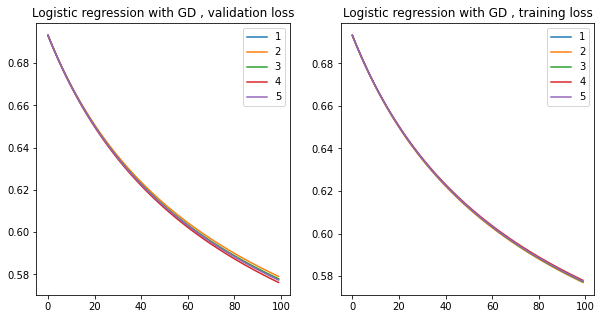

In [93]:
# Test of logistic regularized regression:
with open('parameters/default_parameters.json') as json_file:
    default_parameters = json.load(json_file)
best_w, avg_loss = logistic_regression(tX=tX,
                                    y=y,initial_w=None,
                                    parameters=default_parameters)

## Hyperparameters Tuning

### Randomized Grid search
[Cross-Validation and Hyperparameter Tuning: How to Optimise your Machine Learning Model](https://towardsdatascience.com/cross-validation-and-hyperparameter-tuning-how-to-optimise-your-machine-learning-model-13f005af9d7d)

In [ ]:


def randomized_grid_search(model,
                           tX,
                           y,
                           initial_w,
                           parameters_lists,
                           nb_rnd_test,
                           verbose=False):
    '''
    randomized_grid_search: Search the best parameters with the model among
    a list of value for each parameter.
    @input:
    - string model: 'LS_GD', 'LS_SGD', 'LS_normal', 'RR_normal' or 'LR'
    - np.array(N,m) tX: features
    - np.array(N,) y: labels
    - np.array(m,) initial_w: starting weights for GD and SGD
    - dictionary parameters_lists: A dictionary of lists of values for the parameters
        required for training (lr, lambda, etc)
    - int nb_rnd_test: number of random test to do before giving the best results it found.
    @output
    - double avg_loss: average loss over validation sets during cross-val
    - np.array(m,) best_w: weights that got the smallest loss during cross-val
    - dictionary new_params: hyper-parameters with smallest generalization error
    - int nb_rnd_test: same as the input
    '''
    results = []
    for i in tqdm(range(nb_rnd_test)):
        new_params = {}

        # Select a random combinations of parameters
        for k, v in parameters_lists[model].items():
            new_params[k] = np.random.choice(v)

        param_to_test_with = {model: new_params.copy()}

        # Train the model and store the results
        best_w, avg_loss = train_model(tX, y, model, initial_w,
                                       param_to_test_with, verbose)
        results.append((avg_loss, best_w, param_to_test_with))

    # Return the parameters with the smaller loss
    return sorted(results, key=lambda e: e[0])[0], nb_rnd_test

#### Tuning

##### Generate parameters posibilities (modify these as you want to)

In [ ]:
# Generate parameters (adapt these as you want to) depending on the one we need for the given model
rnd_grid_search_params = {
    'LR': {
        'lambda_': [x for x in np.linspace(0.01, 0.21, 100)],
        'lr': [x for x in np.linspace(0.01, 0.21, 100)],
        'max_iters': [int(x) for x in np.linspace(10, 200, 20)],
        'K': [int(i) for i in np.linspace(1, 10, 10)],
        'poly': [i for i in range(1, 5)]
    },
    'LS_GD': {
        'lr': [x for x in np.linspace(0.01, 0.21, 100)],
        'max_iters': [int(x) for x in np.linspace(10, 200, 20)],
        'K': [int(i) for i in np.linspace(1, 10, 10)],
        'poly': [i for i in range(1, 5)]
    },
    'LS_SGD': {
        'lr': [x for x in np.linspace(0.01, 0.21, 100)],
        'max_iters': [int(x) for x in np.linspace(10, 200, 20)],
        'K': [int(i) for i in np.linspace(1, 10, 10)],
        'poly': [i for i in range(1, 5)],
        'batch_size': [1]
    },
    'LS_normal': {
        'max_iters': [1],
        'K': [int(i) for i in np.linspace(1, 10, 10)],
        'poly': [i for i in range(1, 5)]
    },
    'RR_normal': {
        'max_iters': [1],
        'K': [int(i) for i in np.linspace(1, 10, 10)],
        'lambda_': [x for x in np.linspace(0.01, 0.21, 100)],
        'poly': [i for i in range(1, 5)]
    }
}

In [ ]:
experiments = 25
with open('parameters.json') as json_file:
    parameters = json.load(json_file)
    
model = 'LR'
results = []
for i in tqdm(range(experiments)):
    
    # sample from a Uniform distribution on a log-scale
    # Sample learning rate candidates in the range (0.3 to 0.03)
    lr = 3*10**np.random.uniform(-1,-2) 
    # Sample regularization candidates in the range (0.1 to 0.001)
    lambda_ = 10**np.random.uniform(-1,-3) 
    parameters[model]['lr'] = lr
    parameters[model]['lambda_'] = lambda_

    best_w, avg_loss = train_model(tX=tX,
                               model=model,
                               y=y,
                               initial_w=None,
                               param=parameters, verbose = False)
    results.append((avg_loss, best_w, parameters[model]))
sorted(results, key=lambda e: e[0])[0]   

In [ ]:
from datetime import datetime


def search_and_save_params(model,
                           tX,
                           y,
                           initial_w,
                           parameters_lists,
                           nb_rnd_test,
                           verbose=False):
    
    result = randomized_grid_search(model,
                                    tX,
                                    y,
                                    initial_w,
                                    parameters_lists,
                                    nb_rnd_test,
                                    verbose=False)
    
    now = datetime.now().strftime('%m(month)-%d_%Hh%Mm%Ss')
    model = list(result[0][2].keys())[0]

    OUTPUT_PATH = '../data/results/param_tuning_' + model + '_' + str(
        now) + '.txt'

    data = str('avg_loss:{}\nparameters:{}\nnb_rnd_try:{}\nw:{}'.format(
        result[0][0], result[0][2], result[1], result[0][1]))

    with open(OUTPUT_PATH, 'w') as output:
        output.write(str(data))

##################################################################
# /!\ If this fail, create a directory named 'results' in 'data' #
##################################################################

In [ ]:
search_and_save_params(model='LS_normal',
                       tX=tX,
                       y=y,
                       initial_w=None,
                       parameters_lists=rnd_grid_search_params,
                       nb_rnd_test=50,
                       verbose=False)

## Training with special parameters: 

For other parameters than in the default, change json or create a new dict.

Logistic regression with GD starting with: 
Initial_w: None,
Parameters:{'lambda_': 0.02, 'lr': 0.18, 'max_iters': 250, 'K': 5, 'poly': 2}
------------------
START TRAINING:
Data shape:(250000, 61)
K = 1
Final loss:0.4702313858969793
Final accuracy:77.858
------------------
K = 2
Final loss:0.47241567589085437
Final accuracy:77.80799999999999
------------------
K = 3
Final loss:0.471520209126478
Final accuracy:77.888
------------------
K = 4
Final loss:0.46889169887778054
Final accuracy:77.842
------------------
K = 5
Final loss:0.4677300210307117
Final accuracy:77.926
------------------
Average loss: 0.47015779816456077
------------------
Loss evolution:


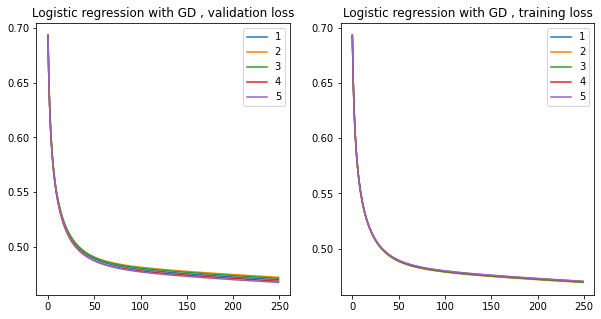

In [94]:
## Training with k-fold:
model = 'LR'

with open('parameters/parameters.json') as json_file:
    parameters = json.load(json_file)

best_w, avg_loss = train_model(tX=tX,
                               model=model,
                               y=y,
                               initial_w=None,
                               param=parameters)

## Generate predictions and save ouput in csv format for submission:

In [95]:
DATA_TEST_PATH = '../data/test.csv' # TODO: download test data and supply path here 
_, tX_test, ids_test = load_csv_data(DATA_TEST_PATH)
print(f'test data shape: X {tX_test.shape}')

test data shape: X (568238, 30)


#### Preprocess X_Test as tX:

In [96]:
invalid_identifier = -999
tX_test_invalid, medians = replace_invalid_values(tX_test,
                                              invalid_identifier,
                                              mean=False)

In [97]:
delta = 1.5
tX_test_filtered, medians = replace_outlayers_values(tX_test_invalid,
                                                     delta,
                                                     mean=False)

In [98]:
tX_test = tX_test_filtered

In [99]:
# Standard par rapport à moyenne et std de train:
POLY = parameters[model]['poly']

poly_X_test =  poly_feats(tX_test, POLY)
poly_X_train = poly_feats(tX, POLY)

mean_train = np.mean(poly_X_train[:,1:], axis=0)
std_train = np.std(poly_X_train[:,1:] - mean_train, axis=0)

tX_test_std = standardize_with_mean_std(poly_X_test, mean_train, std_train)

In [100]:
# Choose method: 
from datetime import date
today = date.today().strftime('%m-%d')

# parameters:
params = ''
for param in parameters[model]:
    params+= param+'='+str(parameters[model][param])+','
    
if not os.path.exists('../data/results'):
    os.makedirs('../data/results')
    
import pandas as pd
test_prediction = predict_labels(best_w, tX_test_std)
OUTPUT_PATH = '../data/results/y_pred_' + model + '_'+str(today)+'_'+params+'.csv'
ids_test = pd.read_csv('../data/sample-submission.csv')['Id']
create_csv_submission(ids_test, test_prediction, OUTPUT_PATH)

In [134]:
good_pred = pd.read_csv('../data/results/y_pred_LR_10-18_lambda_=0.02,lr=0.18,max_iters=250,K=5,poly=2,.csv')

In [135]:
good_pred

,Id,Prediction
0,350000,-1
1,350001,-1
2,350002,-1
3,350003,1
4,350004,-1
...,...,...
568233,918233,-1
568234,918234,-1
568235,918235,-1
568236,918236,1


In [136]:
def predict_labels(weights, data):
    """Generates class predictions given weights, and a test data matrix"""
    y_pred = np.dot(data, weights)
    y_pred[np.where(y_pred <= 0)] = -1
    y_pred[np.where(y_pred > 0)] = 1
    
    return y_pred

In [137]:
np.all(good_pred['Prediction'].values == predict_labels(best_w, tX_test_std))

True

## Next: 

- Grid search for best parameters
- Pre-processing: look for outliers, etc
- Dimension reduction by PCA or Laplacian dimension reduction.
- Etude comparative
- implentations.py
- Rapport

### Questions: 
- encoding of y : 0vs1 / -1vs1 ? 
- predict labels ? 
Jäggi: more/better data cleaning, preprocessing and feature expansions or variants for example